# Shape analysis of DAVIS

- DAVIS: Dense Annotated VIdeo Segmentation: https://davischallenge.org/index.html

Khoreva, A., Rohrbach, A. and Schiele, B., 2018. Video object segmentation with language referring expressions. arXiv preprint [arXiv:1803.08006](https://arxiv.org/abs/1803.08006).


Importantly, our method does not only apply to cell morphodynamics. In fact, it is generally applicable to all moving simple (Jordan) polygons.

To illustrate this, we perform unsupervised clustering on the DAVIS dataset (Dense Annotated VIdeo Segmentation ([Khoreva et al. 2018](https://arxiv.org/abs/1803.08006))) to separate video sequences of human movements, animal locomotion and moving vehicles.

We took the annotated masks from the 90 video sequences in the DAVIS 2017 dataset and selected the animated objects that were mostly complete within the field of view and contained little or no occlusion. This resulted in 12 binary videos containing animal movement, 22 with human movement (7 walking, 14 doing sports) and 9 videos with vehicles.

Next, we extracted the contours, created a tensor as described in ... and used tensor decomposition (parafac, rank 3) to embed the videos in a 2D space (using UMAP to project from 3D to 2D space). As the result (Figure ??) shows, this suffices for an accurate clustering per activity group in an unsupervised manner. 





In [5]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob
import numpy as np

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
import cellshapy

Reading config from /home/debacwa/.config/cellshapy


/home/debacwa/Work/cellshapy/cellshapy/config/features.py:23: UserWarning: Package mahotas is missing. Some features are not available


# Import data

In [9]:
data_folder = '/data/debacwa/cellshapy/dataset-DAVIS'

- import annotation

In [10]:
import pandas as pd
import os
fn = os.path.join(data_folder, 'annotation.csv')
annotation = pd.read_csv(fn, index_col=0, squeeze=True).to_dict('records')

- import video data

In [23]:
filenames = os.path.join(data_folder, '*.tif')
vc = cellshapy.VideoCollection.from_glob(filenames, annotations=annotation, composite=True, normalize_distances=True)

Creating VideoCollection from glob expression /data/debacwa/cellshapy/dataset-DAVIS/*.tif: 41 video files or directories
Creating VideoCollection from list of paths. 41 video files or directories


Iteration 2, error: 0.000097, time: 3.46 sec
2829 contours aligned in 5.24 sec


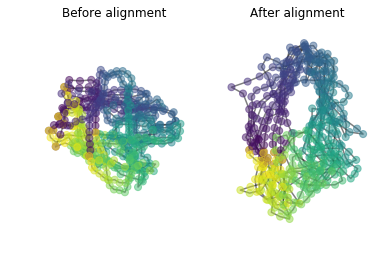

In [24]:
_ = vc.align_contours(show_samples=10)

In [25]:
# rotate shapes by 90 degrees
vc.rotate_shapes(degrees=-90)

# Shape analysis

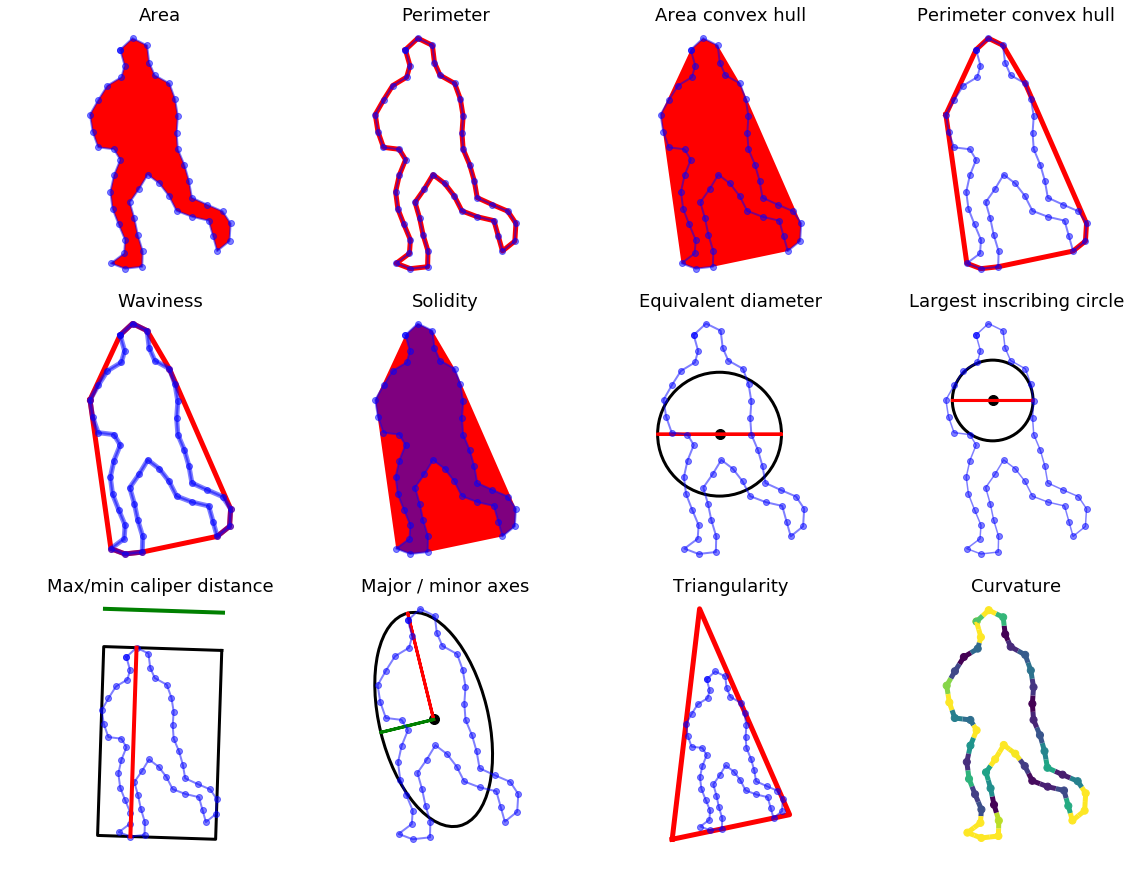

In [26]:
from cellshapy.utils.contours import extract_shape_descriptors
_ = vc[-2][2].extract_shape_descriptors(plot=True, skeleton=False)

# Morph analysis

## VAE

/home/debacwa/Work/cellshapy/cellshapy/data/videocollection.py:717: UserWarning: VAE is experimental! Limited compatibility.
/home/debacwa/Work/cellshapy/cellshapy/analysis/vae.py:66: UserWarning: Tensor was zero-padded from (41, 69, 96) to (41, 80, 96).


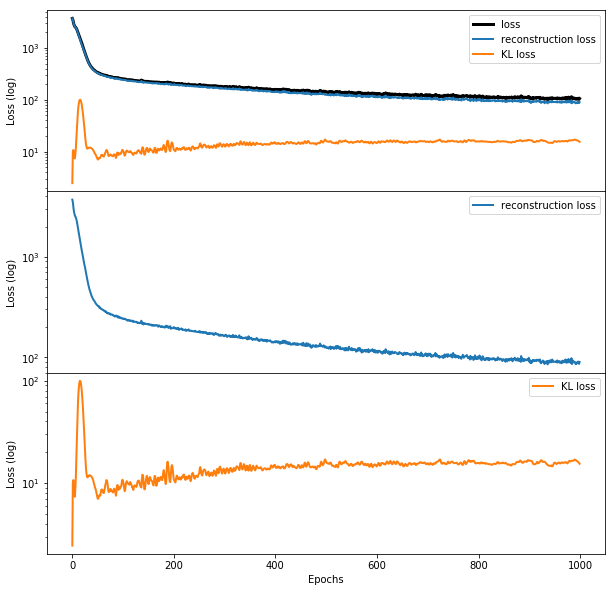

In [144]:
format = 'stxy'
vc.embed_morphs(format, 'vae', n_components=4, plot=False, verbose=False)

components = None


/home/debacwa/Work/cellshapy/cellshapy/plotting/morphspace.py:93: UserWarning: Projecting from 4 components to 2D using umap.


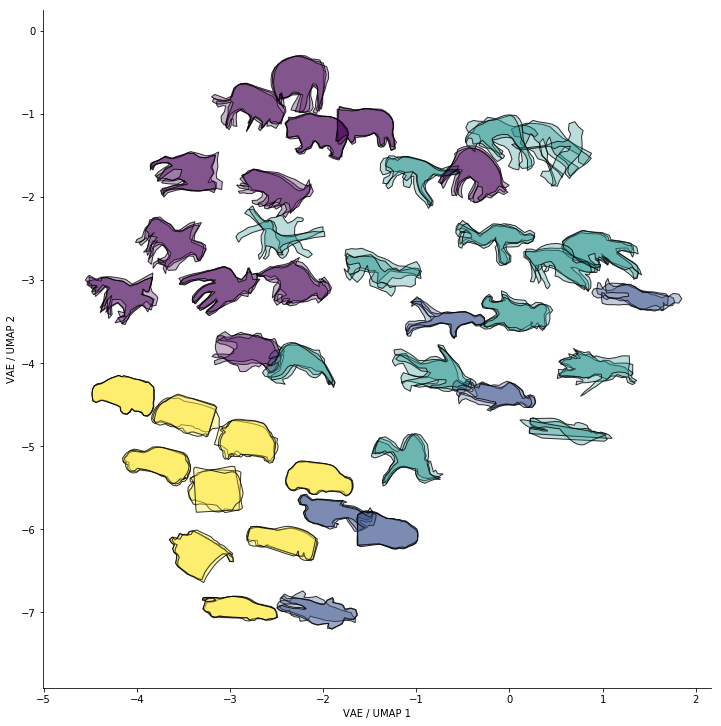

In [178]:
f=60
fig = vc.morph_space(format, 'vae', animate=False, frames=[f,f+2,f+4], 
                         shape_size=70, alpha_face=0.3, alpha_edge=0.7, colorcode='class', projection='umap')

<StemContainer object of 3 artists>

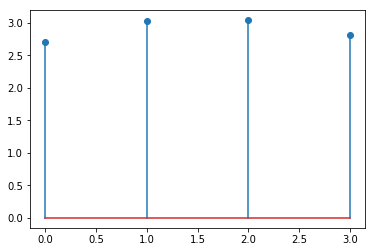

In [146]:
embeddings = vc.embedding[('stxy', 'vae')]
fig, ax = plt.subplots(1,1)
#ax.scatter(range(emb.shape[1]), np.mean(emb, axis=0), s=20, c='k')
#ax.vlines(range(emb.shape[1]), ymin=np.mean(emb, axis=0)-np.std(emb, axis=0), ymax=np.mean(emb, axis=0)+np.std(emb, axis=0))
ax.stem(range(embeddings.shape[1]), np.std(embeddings, axis=0))


## Parafac

`parafac` embedding for `stxy` done (0.18 s).


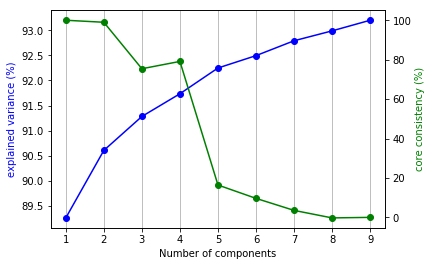

core consistency  explained variance
n_components                                      
1                   100.000000           89.265322
2                    98.973004           90.608938
3                    75.401543           91.283974
4                    79.116601           91.736249
5                    16.424024           92.248460
6                     9.647989           92.494710
7                     3.551233           92.790666
8                    -0.262022           92.987450
9                     0.015205           93.198715

In [147]:
vc.embed_morphs(format, 'parafac', n_components=2, save_embedding=True, plot=False)
df_corcondia, _ = vc.parafac_diagnostics(format, max_components=10)
df_corcondia

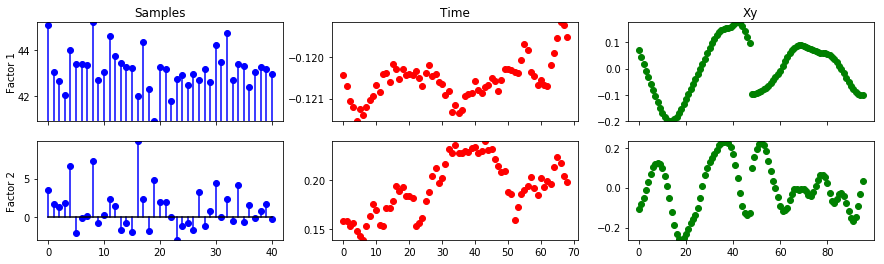

In [217]:
vc.embed_morphs(format, 'parafac', n_components=2, plot=True, verbose=False)

components = None


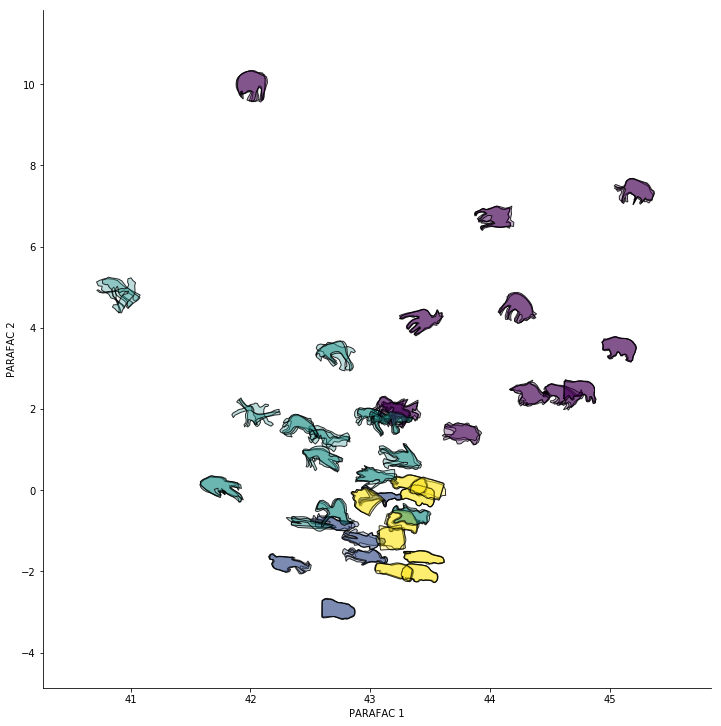

In [219]:
fig = vc.morph_space(format, 'parafac', animate=False, frames=[f,f+2,f+4], 
                         shape_size=100, alpha_face=0.3, alpha_edge=0.7, colorcode='class', projection=None)

/home/debacwa/Work/cellshapy/cellshapy/analysis/embedding.py:1346: UserWarning: Embedding do not have identical dimensionlity (2 != 4). Reducing dimensionality of the one with larger dimensionality with PCA.


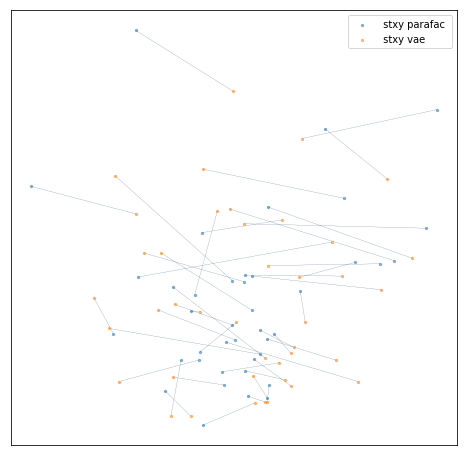

1.2357411935599487

In [220]:
vc.compare_embeddings(('stxy', 'parafac'),('stxy', 'vae'))

## Tucker

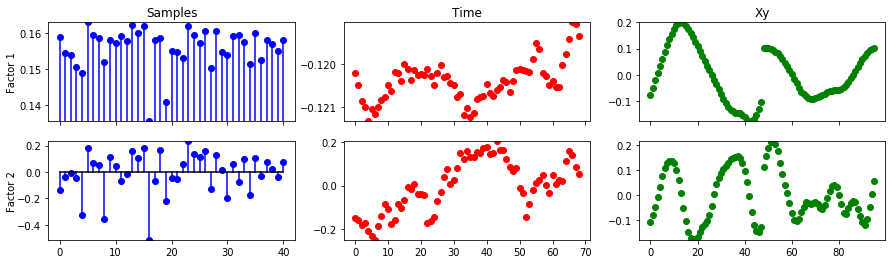

In [221]:
vc.embed_morphs(format, 'tucker', n_components=2, plot=True, verbose=False)

components = None


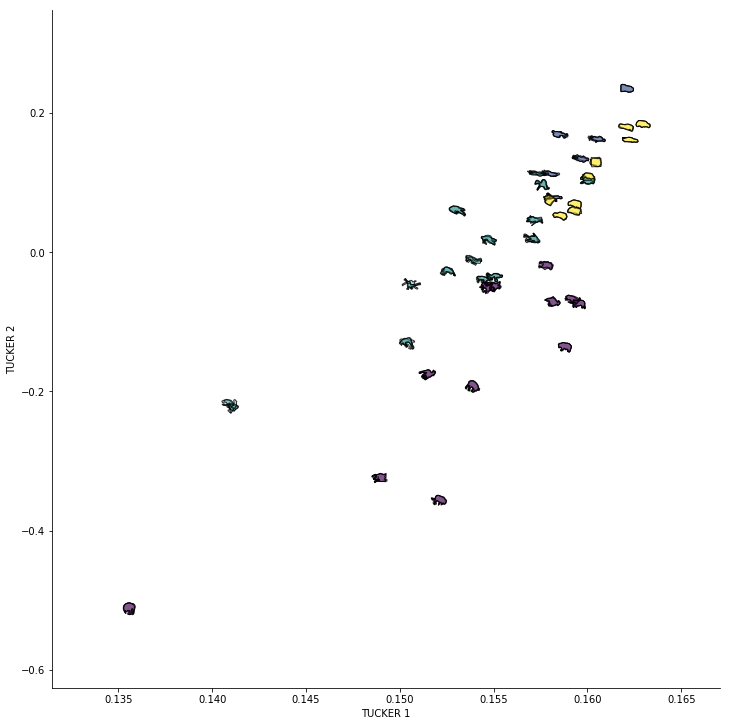

In [222]:
fig = vc.morph_space(format, 'tucker', animate=False, frames=[f,f+2,f+4], 
                         shape_size=350, alpha_face=0.3, alpha_edge=0.7, colorcode='class', projection=None)

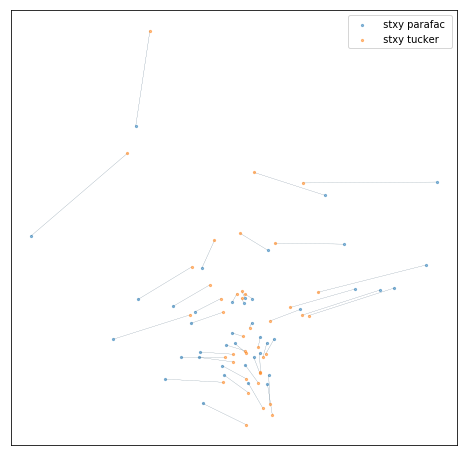

0.7417731439418783

In [223]:
vc.compare_embeddings(('stxy', 'parafac'),('stxy', 'tucker'))

/home/debacwa/Work/cellshapy/cellshapy/analysis/embedding.py:1346: UserWarning: Embedding do not have identical dimensionlity (2 != 4). Reducing dimensionality of the one with larger dimensionality with PCA.


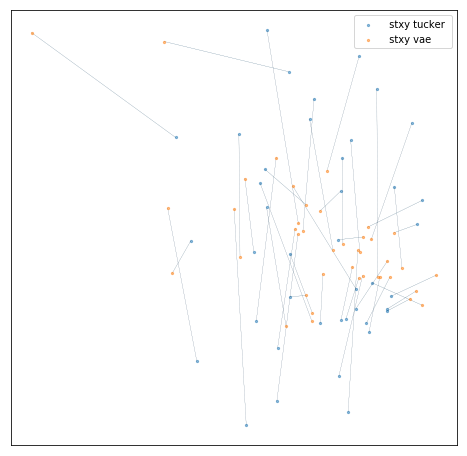

1.189583295376577

In [224]:
vc.compare_embeddings(('stxy', 'tucker'),('stxy', 'vae'))